In [255]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from statsmodels.tsa.deterministic import DeterministicProcess

In [256]:
# Set Matplotlib defaults
plt.rc("figure", autolayout=True, figsize=(11, 4))
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=14,
    titlepad=10,
)
plot_params = dict(
    color="0.75",
    style=".-",
    markeredgecolor="0.25",
    markerfacecolor="0.25",
    legend=False,
)
%config InlineBackend.figure_format = 'retina'

sns.set(style="whitegrid")

In [257]:
df = pd.read_csv('shampoo_sales.csv',
                index_col='Month')

In [258]:
def custom_date_parser(date):
    year = 1981 + int(date.split('-')[0]) - 1
    month = int(date.split('-')[1])
    return pd.to_datetime(f'{year}-{month:02}')

In [259]:
df.index = df.index.to_series().apply(custom_date_parser)

In [260]:
df = df.to_period()

In [261]:
df.head()

,Sales
Month,
1981-01,266.0
1981-02,145.9
1981-03,183.1
1981-04,119.3
1981-05,180.3


## Fitting a linear regression model for Month feature

In [262]:
df['Month'] = np.arange(len(df.index))

In [263]:
# Training data
X = df.loc[:, ['Month']] # features
y = df.loc[:, 'Sales'] # target

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.33, shuffle=False)

# Train model
model = LinearRegression()
model.fit(X_train,y_train)

LinearRegression()

In [264]:
y_train_pred = pd.Series(model.predict(X_train), index=X_train.index)

In [265]:
y_test_pred = pd.Series(model.predict(X_test), index=X_test.index)

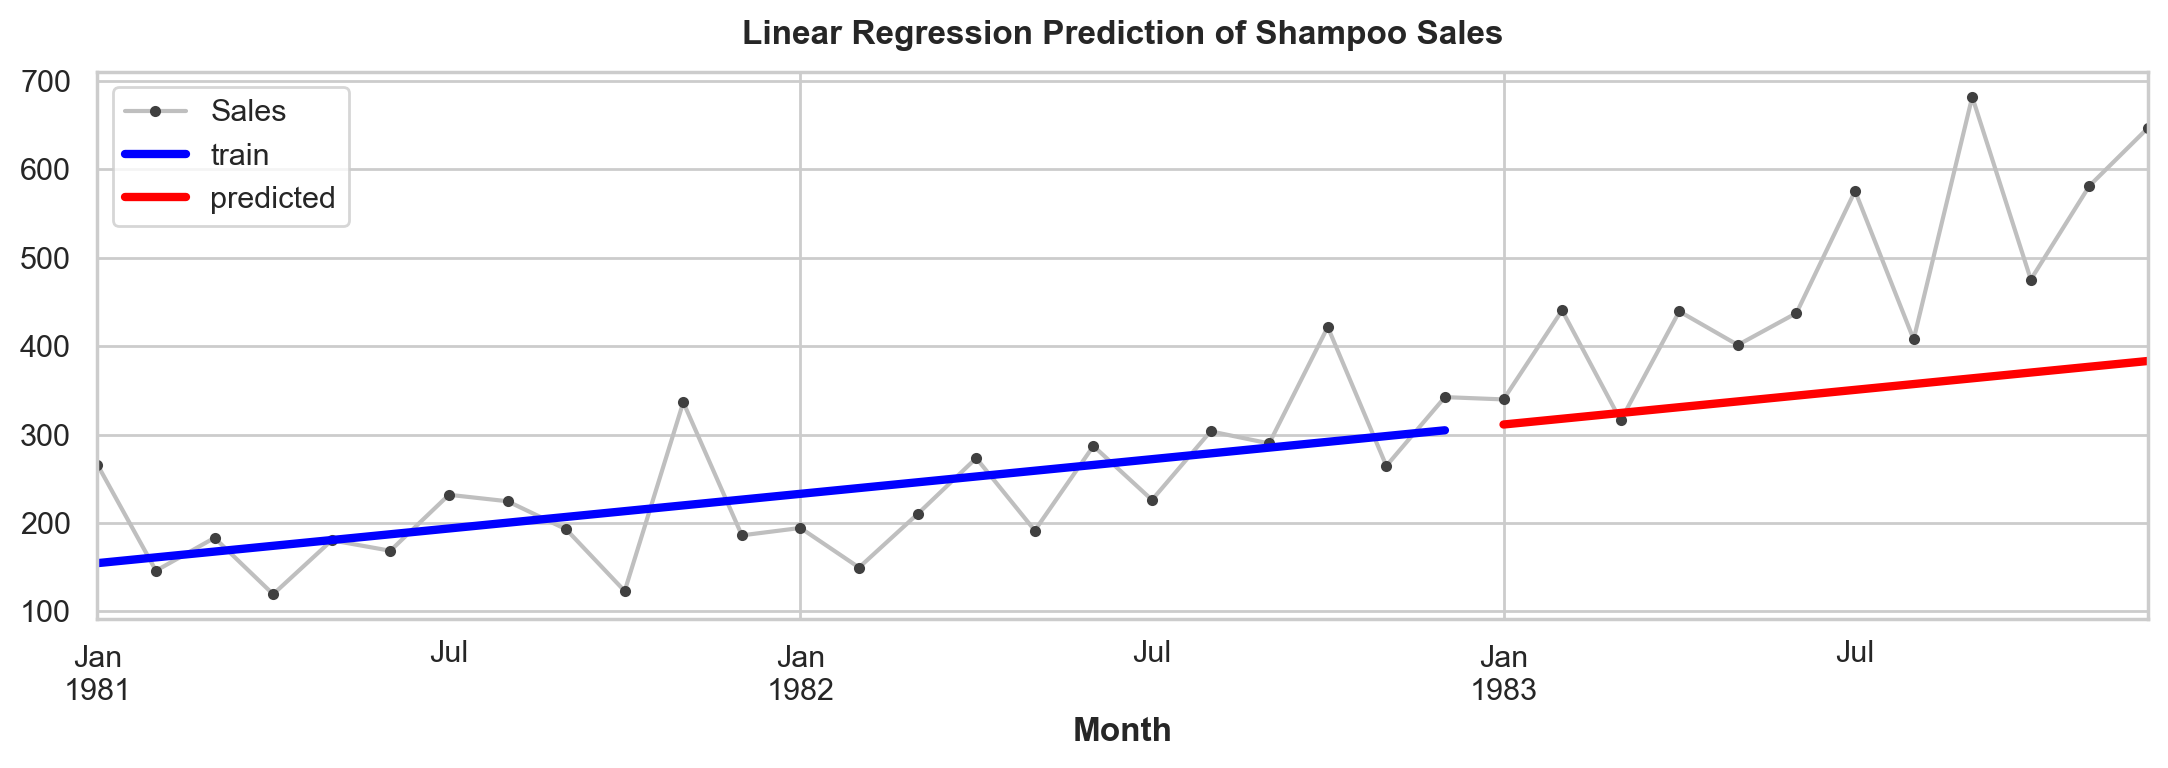

In [266]:
ax = y.plot(**plot_params)
ax = y_train_pred.plot(ax=ax, linewidth=3, color='blue', label='train')
ax = y_test_pred.plot(ax=ax, linewidth=3, color='red', label='predicted')
ax.set_title('Linear Regression Prediction of Shampoo Sales')
ax.legend();
plt.savefig('linear_regression_prediction.png')
plt.show()

In [267]:
mae = mean_absolute_error(y_test, y_test_pred)
print('Mean Absolute Error (MAE):', mae)

Mean Absolute Error (MAE): 132.7094275362319


## Fitting a quadratic regression model for Month feature

In [268]:
X = X.copy()

dp = DeterministicProcess(
    index=X.index,
    constant=True,
    order=2,
    drop=True,
)

X = dp.in_sample()

X.head()

,const,trend,trend_squared
Month,,,
1981-01,1.0,1.0,1.0
1981-02,1.0,2.0,4.0
1981-03,1.0,3.0,9.0
1981-04,1.0,4.0,16.0
1981-05,1.0,5.0,25.0


In [269]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.33, shuffle=False)

model = LinearRegression(fit_intercept=False)
model.fit(X_train, y_train)

LinearRegression(fit_intercept=False)

In [270]:
y_train_pred = pd.Series(model.predict(X_train), index=X_train.index)

In [271]:
y_test_pred = pd.Series(model.predict(X_test), index=X_test.index)

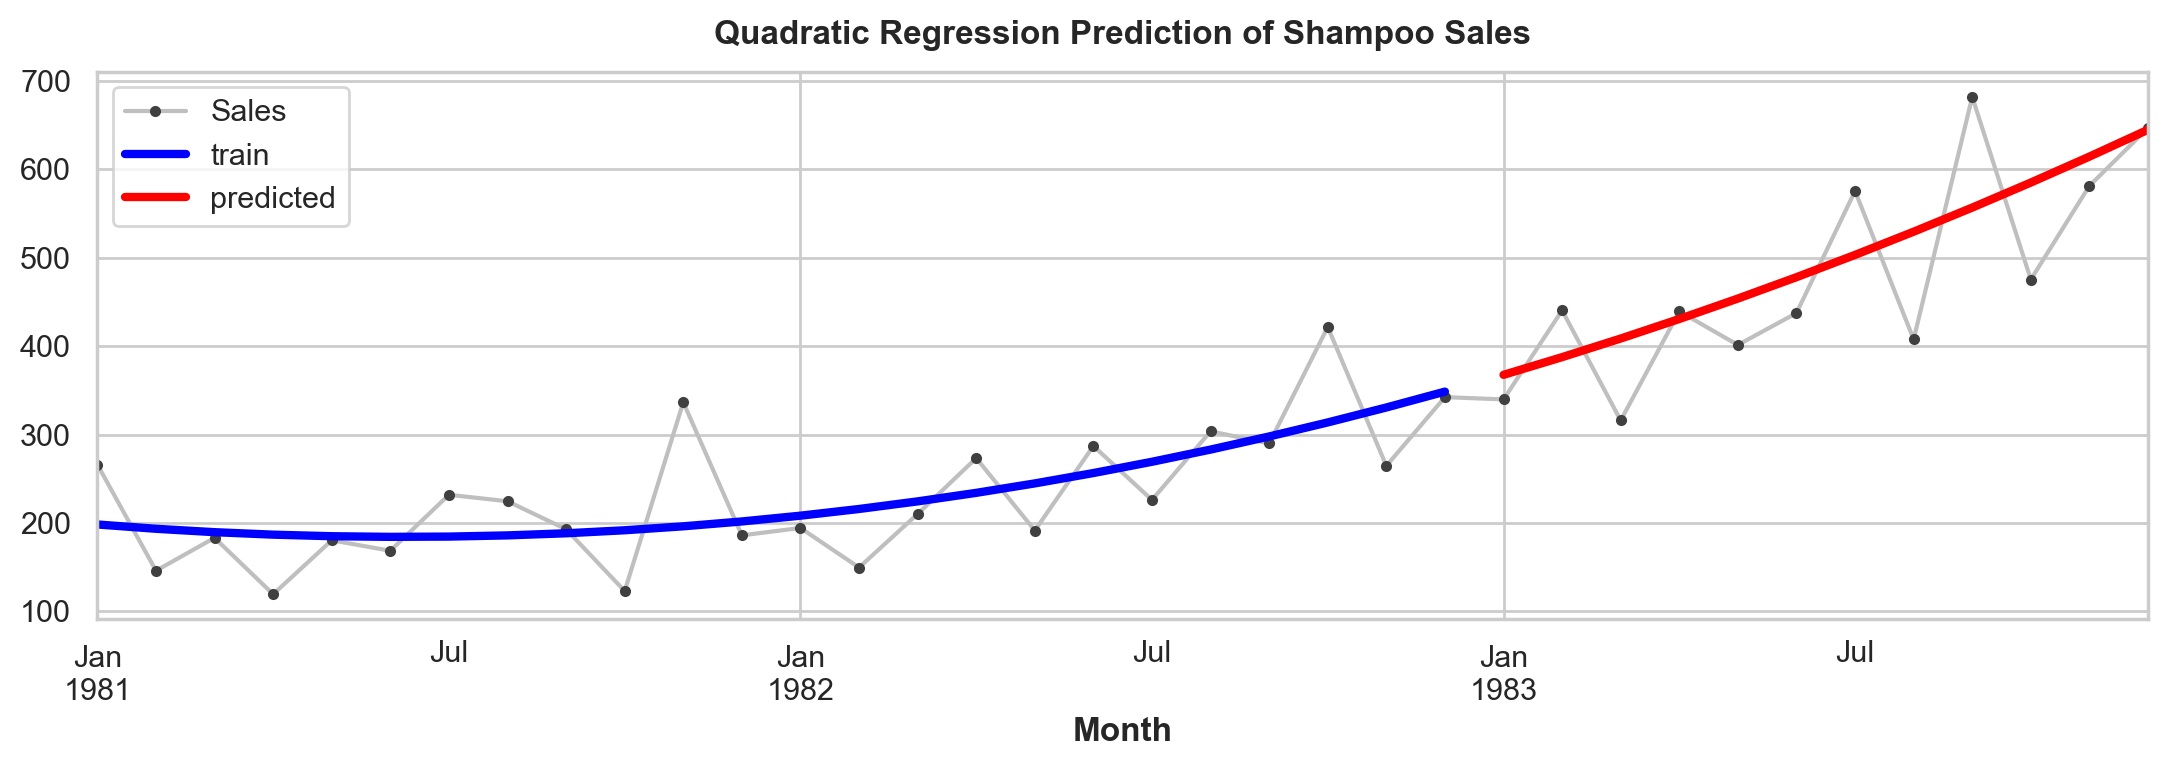

In [272]:
ax = y.plot(**plot_params)
ax = y_train_pred.plot(ax=ax, linewidth=3, color='blue', label='train')
ax = y_test_pred.plot(ax=ax, linewidth=3, color='red', label='predicted')
ax.set_title('Quadratic Regression Prediction of Shampoo Sales')
ax.legend();
plt.savefig('Quadratic_regression_prediction.png')
plt.show()

In [273]:
mae = mean_absolute_error(y_test, y_test_pred)
print('Mean Absolute Error (MAE):', mae)

Mean Absolute Error (MAE): 61.62083855275131


## Data Stationarization

In [274]:
from statsmodels.tsa.stattools import adfuller

result = adfuller(df['Sales'])
print('ADF Statistic:', result[0])
print('p-value:', result[1])

ADF Statistic: 3.0601420836411806
p-value: 1.0


In [275]:
df['Sales_diff'] = df['Sales'].diff().dropna()

In [276]:
result = adfuller(df['Sales_diff'].dropna())
print('ADF Statistic:', result[0])
print('p-value:', result[1])

ADF Statistic: -7.249074055553854
p-value: 1.7998574141687034e-10


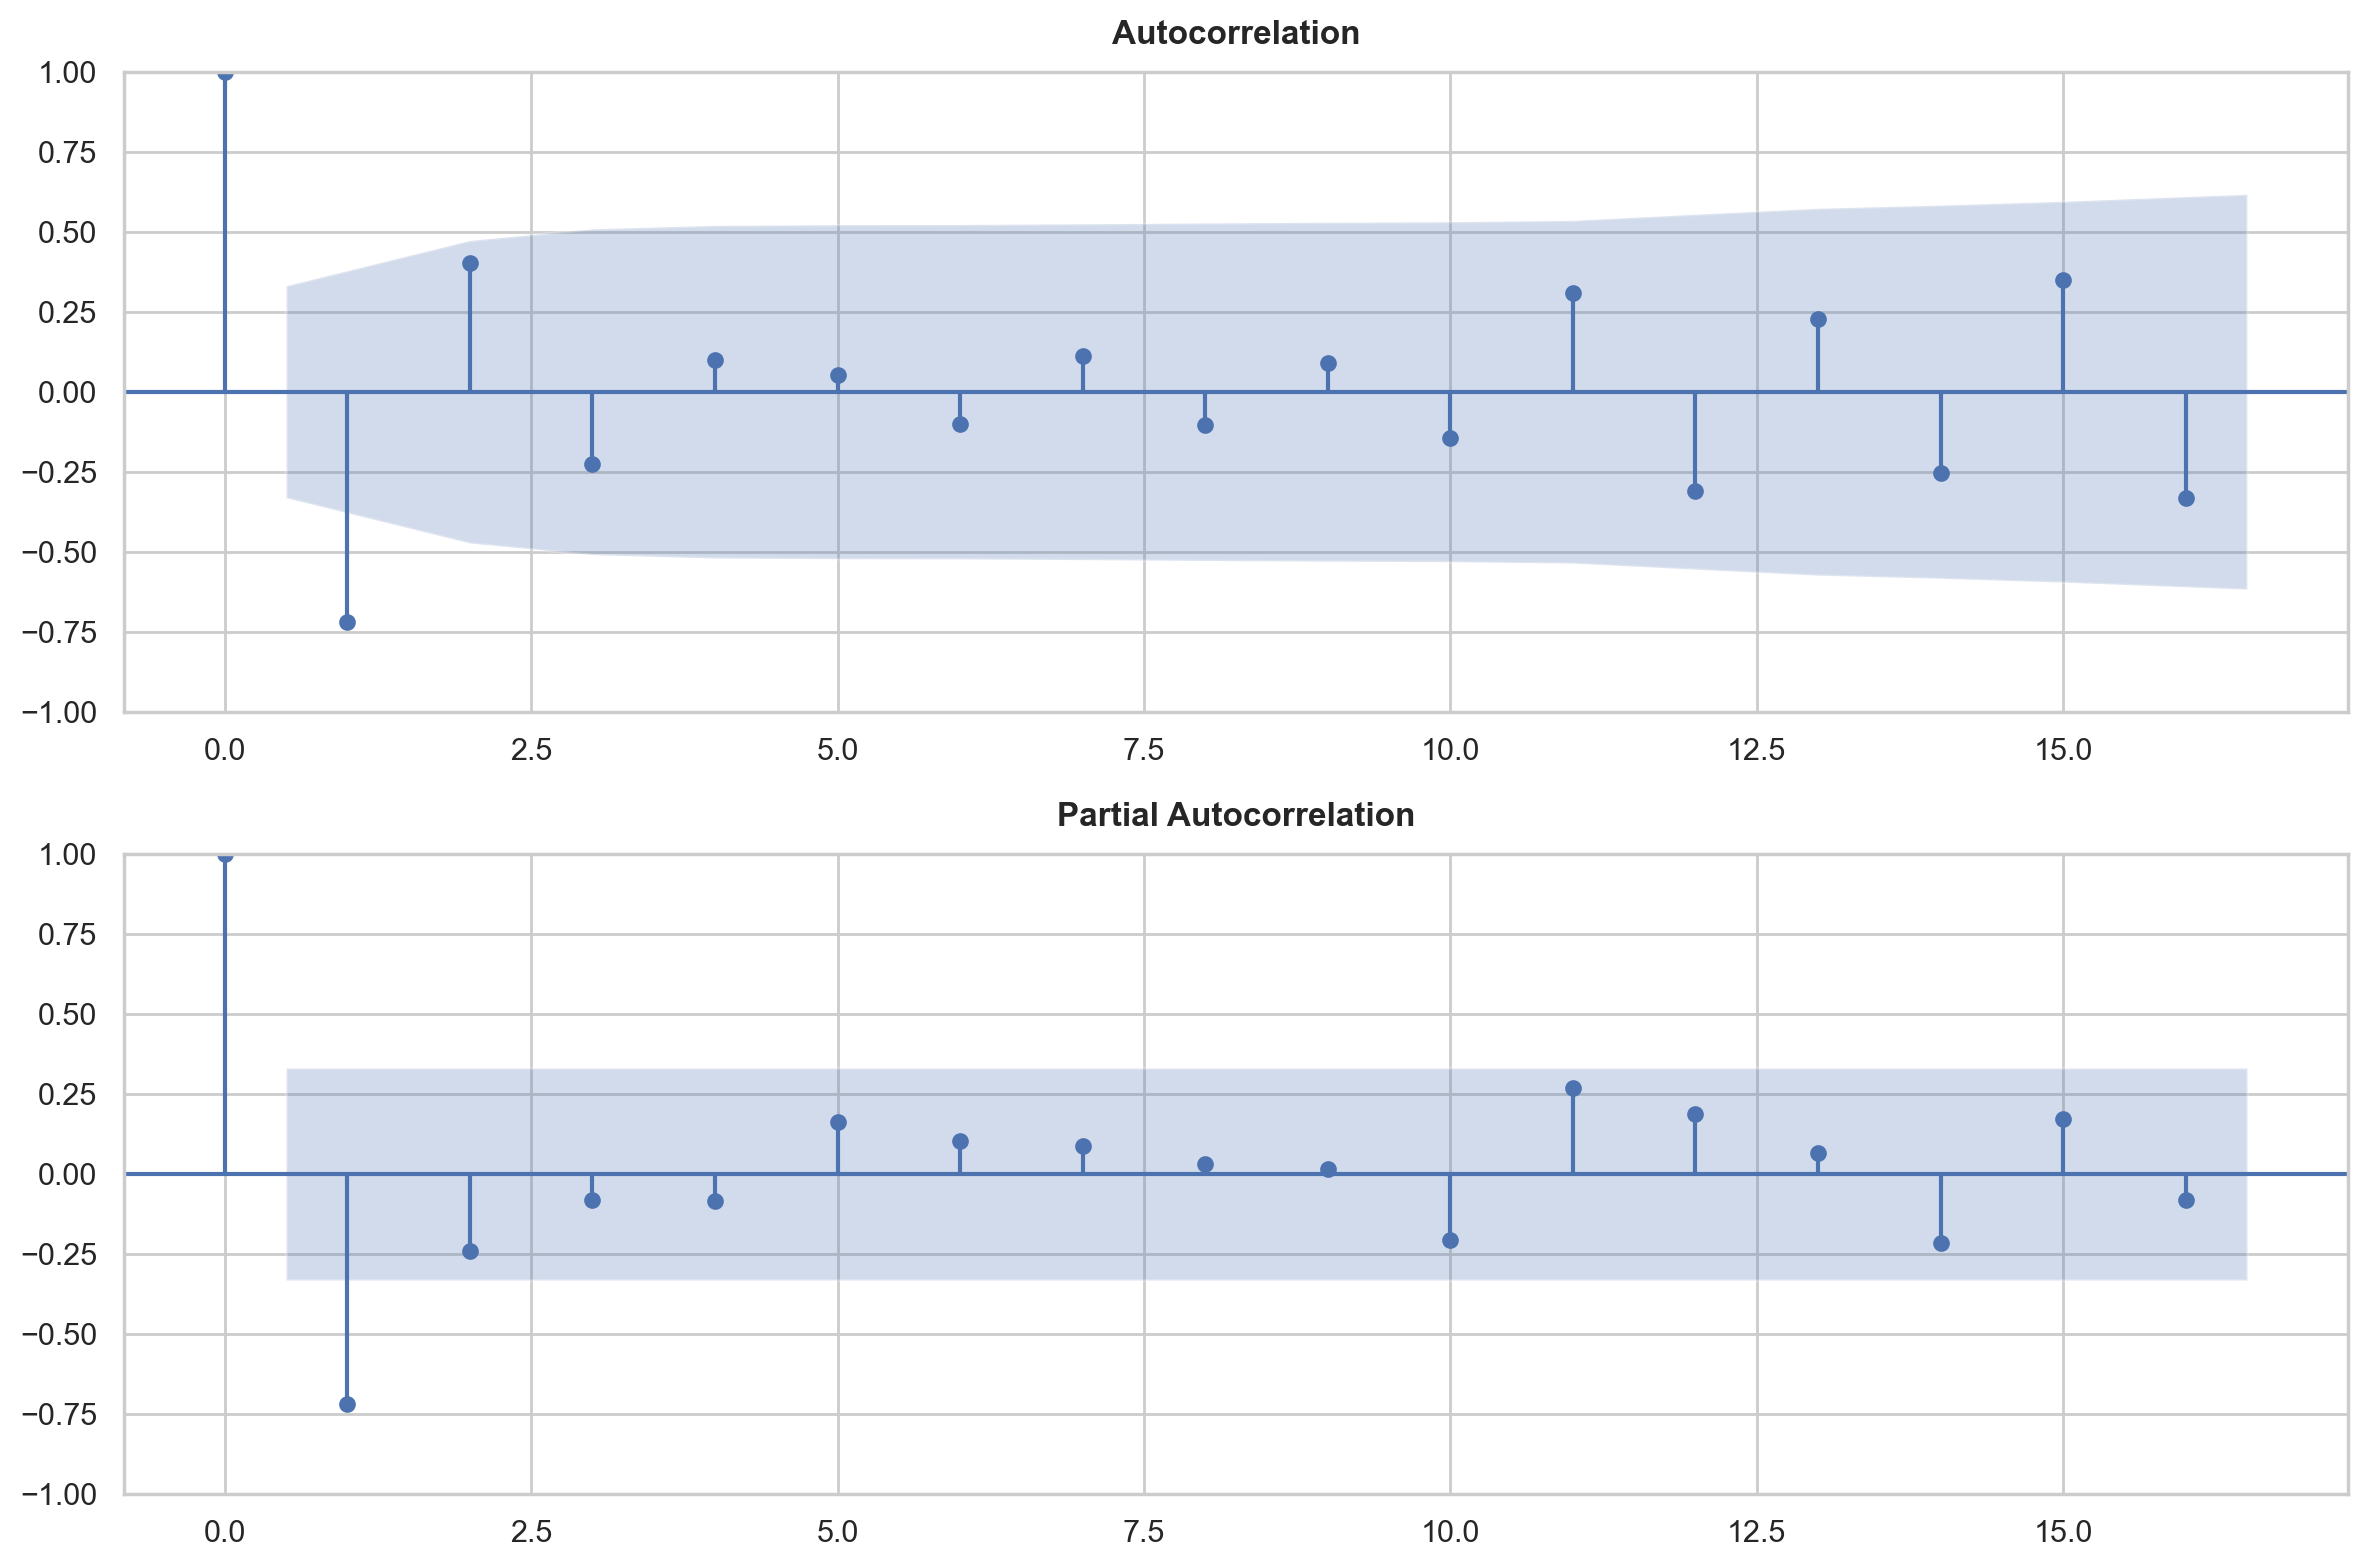

In [277]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

fig, ax = plt.subplots(2, 1, figsize=(12, 8))
plot_acf(df['Sales_diff'].dropna(), ax=ax[0])
plot_pacf(df['Sales_diff'].dropna(), ax=ax[1])
plt.savefig('ACF_PACF.png')
plt.show()

## ARIMA

In [278]:
df.head()

,Sales,Month,Sales_diff
Month,,,
1981-01,266.0,0,NaN
1981-02,145.9,1,-120.1
1981-03,183.1,2,37.2
1981-04,119.3,3,-63.8
1981-05,180.3,4,61.0


In [279]:
from statsmodels.tsa.arima.model import ARIMA
# Training data
train, test = train_test_split(df, test_size=0.33, shuffle=False)

In [280]:
# Train model
model = ARIMA(train['Sales_diff'].dropna(), order=(5, 0, 8))
model_fit = model.fit()
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:             Sales_diff   No. Observations:                   23
Model:                 ARIMA(5, 0, 8)   Log Likelihood                -125.993
Date:                Sun, 26 Jan 2025   AIC                            281.986
Time:                        21:10:26   BIC                            299.018
Sample:                    02-28-1981   HQIC                           286.269
                         - 12-31-1982                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          6.0662     19.307      0.314      0.753     -31.775      43.907
ar.L1         -0.3959     15.536     -0.025      0.980     -30.845      30.053
ar.L2         -1.6238      2.071     -0.784      0.4

In [281]:
forecast = model_fit.forecast(steps=len(test))

In [282]:
forecast

1983-01     5.755723
1983-02    75.371920
1983-03   -74.011268
1983-04     9.964653
1983-05    22.997164
1983-06     7.998957
1983-07     6.380439
1983-08    27.460741
1983-09   -20.877795
1983-10   -28.318106
1983-11    45.944043
1983-12    48.032298
Freq: M, Name: predicted_mean, dtype: float64

In [283]:
forecast_diff_reverted = forecast.cumsum() + train['Sales'].iloc[-1]
forecast_diff_reverted

1983-01    348.055723
1983-02    423.427643
1983-03    349.416375
1983-04    359.381028
1983-05    382.378192
1983-06    390.377148
1983-07    396.757587
1983-08    424.218328
1983-09    403.340533
1983-10    375.022427
1983-11    420.966470
1983-12    468.998768
Freq: M, Name: predicted_mean, dtype: float64

In [284]:
mae = mean_absolute_error(y_test, forecast_diff_reverted)
print('Mean Absolute Error (MAE):', mae)

Mean Absolute Error (MAE): 93.10338593683146


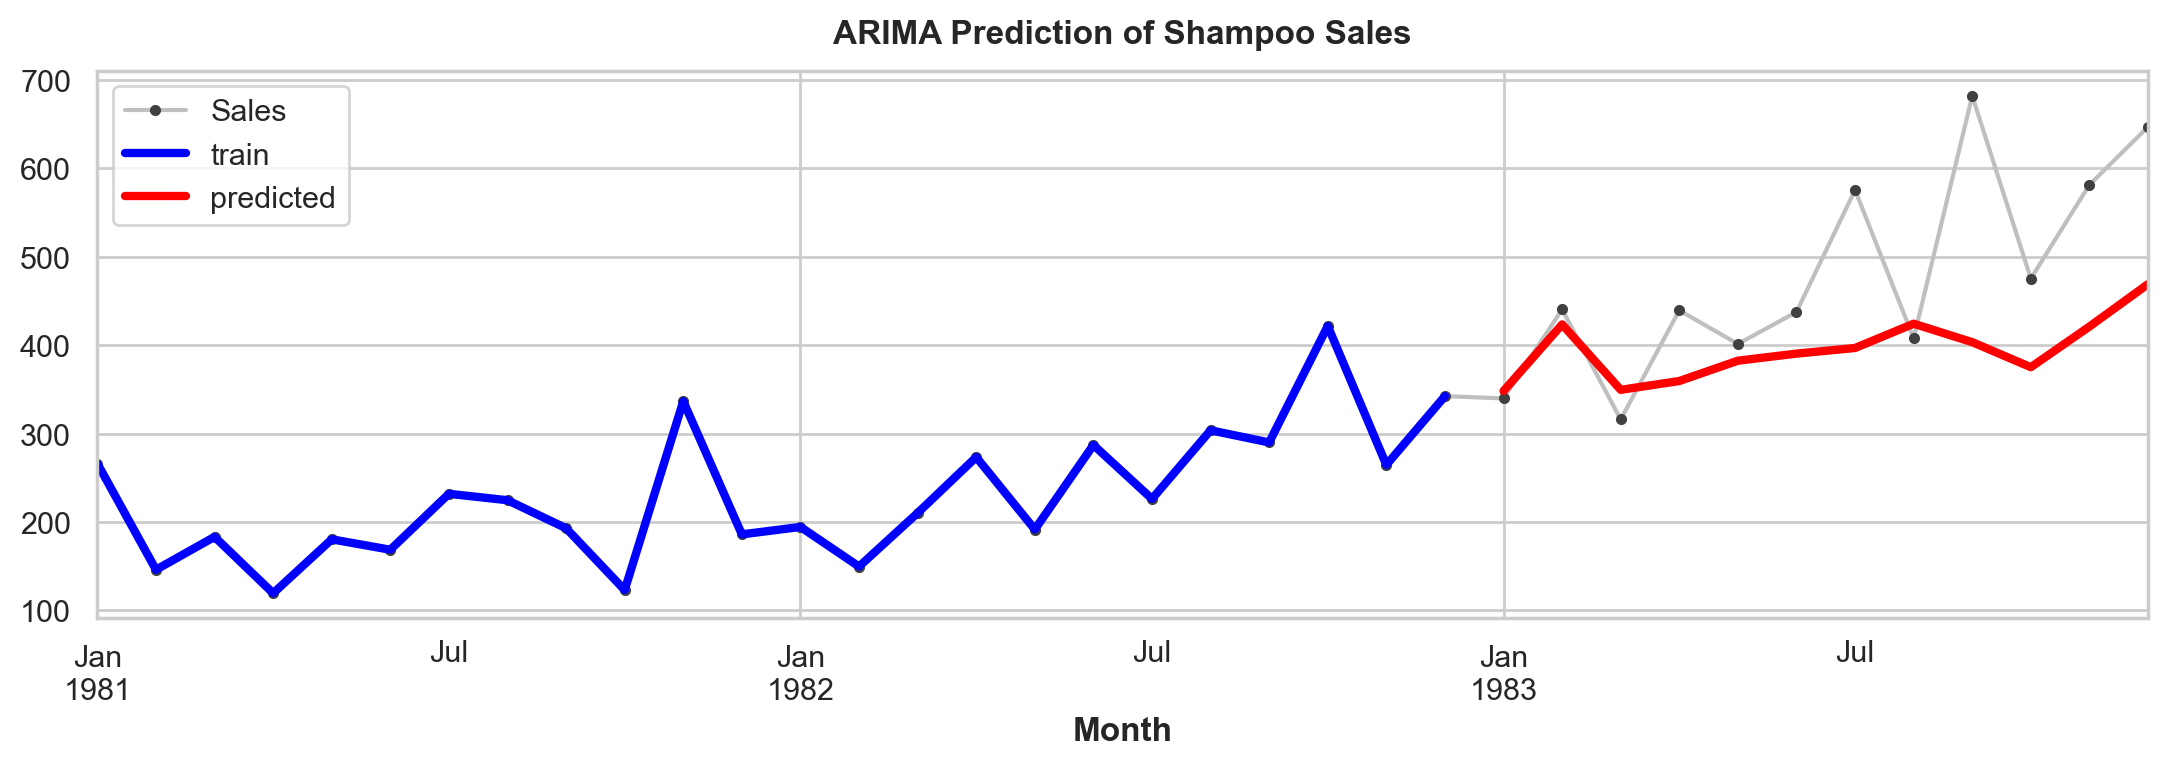

In [285]:
ax = df['Sales'].plot(**plot_params)
ax = train['Sales'].plot(ax=ax, linewidth=3, color='blue', label='train')
ax = forecast_diff_reverted.plot(ax=ax, linewidth=3, color='red', label='predicted')
ax.set_title('ARIMA Prediction of Shampoo Sales')
ax.legend();
plt.show()

### Grid Search

In [296]:
import itertools
import warnings

#warnings.filterwarnings("ignore")

# Definování rozsahu pro parametry p a q, s d = 0
p = q = range(0, 10)  # Změna rozsahu podle potřeby
pdq = [(x[0], 1, x[1]) for x in list(itertools.product(p, q))]
print(pdq)

# Funkce pro grid search s MAE
def arima_grid_search(train, test, pdq):
    best_mae = np.inf
    best_order = None
    best_model = None
    
    for order in pdq:
        try:
            model = ARIMA(train['Sales_diff'].dropna(), order=order)
            model_fit = model.fit()
            forecast = model_fit.forecast(steps=len(test))
            print(model_fit.summary())
            
            # Invertování diferenciace
            forecast_diff_reverted = forecast.cumsum() + train['Sales'].iloc[-1]
            
            # Výpočet MAE
            mae = mean_absolute_error(test, forecast_diff_reverted)
            print(mae)
            if mae < best_mae:
                best_mae = mae
                best_order = order
                best_model = model_fit
        except:
            continue
    return best_order, best_model

# Provedení grid search
best_order, best_model = arima_grid_search(train, y_test, pdq)
print(f"Best order: {best_order}")
print(best_model.summary())

[(0, 1, 0), (0, 1, 1), (0, 1, 2), (0, 1, 3), (0, 1, 4), (0, 1, 5), (0, 1, 6), (0, 1, 7), (0, 1, 8), (0, 1, 9), (1, 1, 0), (1, 1, 1), (1, 1, 2), (1, 1, 3), (1, 1, 4), (1, 1, 5), (1, 1, 6), (1, 1, 7), (1, 1, 8), (1, 1, 9), (2, 1, 0), (2, 1, 1), (2, 1, 2), (2, 1, 3), (2, 1, 4), (2, 1, 5), (2, 1, 6), (2, 1, 7), (2, 1, 8), (2, 1, 9), (3, 1, 0), (3, 1, 1), (3, 1, 2), (3, 1, 3), (3, 1, 4), (3, 1, 5), (3, 1, 6), (3, 1, 7), (3, 1, 8), (3, 1, 9), (4, 1, 0), (4, 1, 1), (4, 1, 2), (4, 1, 3), (4, 1, 4), (4, 1, 5), (4, 1, 6), (4, 1, 7), (4, 1, 8), (4, 1, 9), (5, 1, 0), (5, 1, 1), (5, 1, 2), (5, 1, 3), (5, 1, 4), (5, 1, 5), (5, 1, 6), (5, 1, 7), (5, 1, 8), (5, 1, 9), (6, 1, 0), (6, 1, 1), (6, 1, 2), (6, 1, 3), (6, 1, 4), (6, 1, 5), (6, 1, 6), (6, 1, 7), (6, 1, 8), (6, 1, 9), (7, 1, 0), (7, 1, 1), (7, 1, 2), (7, 1, 3), (7, 1, 4), (7, 1, 5), (7, 1, 6), (7, 1, 7), (7, 1, 8), (7, 1, 9), (8, 1, 0), (8, 1, 1), (8, 1, 2), (8, 1, 3), (8, 1, 4), (8, 1, 5), (8, 1, 6), (8, 1, 7), (8, 1, 8), (8, 1, 9), (9, 1, 0)

In [297]:
# Train model
model = ARIMA(train['Sales_diff'].dropna(), order=(7, 1, 3))
model_fit = model.fit()
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:             Sales_diff   No. Observations:                   23
Model:                 ARIMA(7, 1, 3)   Log Likelihood                -120.417
Date:                Sun, 26 Jan 2025   AIC                            262.835
Time:                        21:32:01   BIC                            274.836
Sample:                    02-28-1981   HQIC                           265.662
                         - 12-31-1982                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -2.4141      3.264     -0.740      0.460      -8.811       3.983
ar.L2         -3.3988      5.317     -0.639      0.523     -13.820       7.022
ar.L3         -4.2781      7.161     -0.597      0.5

In [298]:
forecast = model_fit.forecast(steps=len(test))
forecast_diff_reverted = forecast.cumsum() + train['Sales'].iloc[-1]

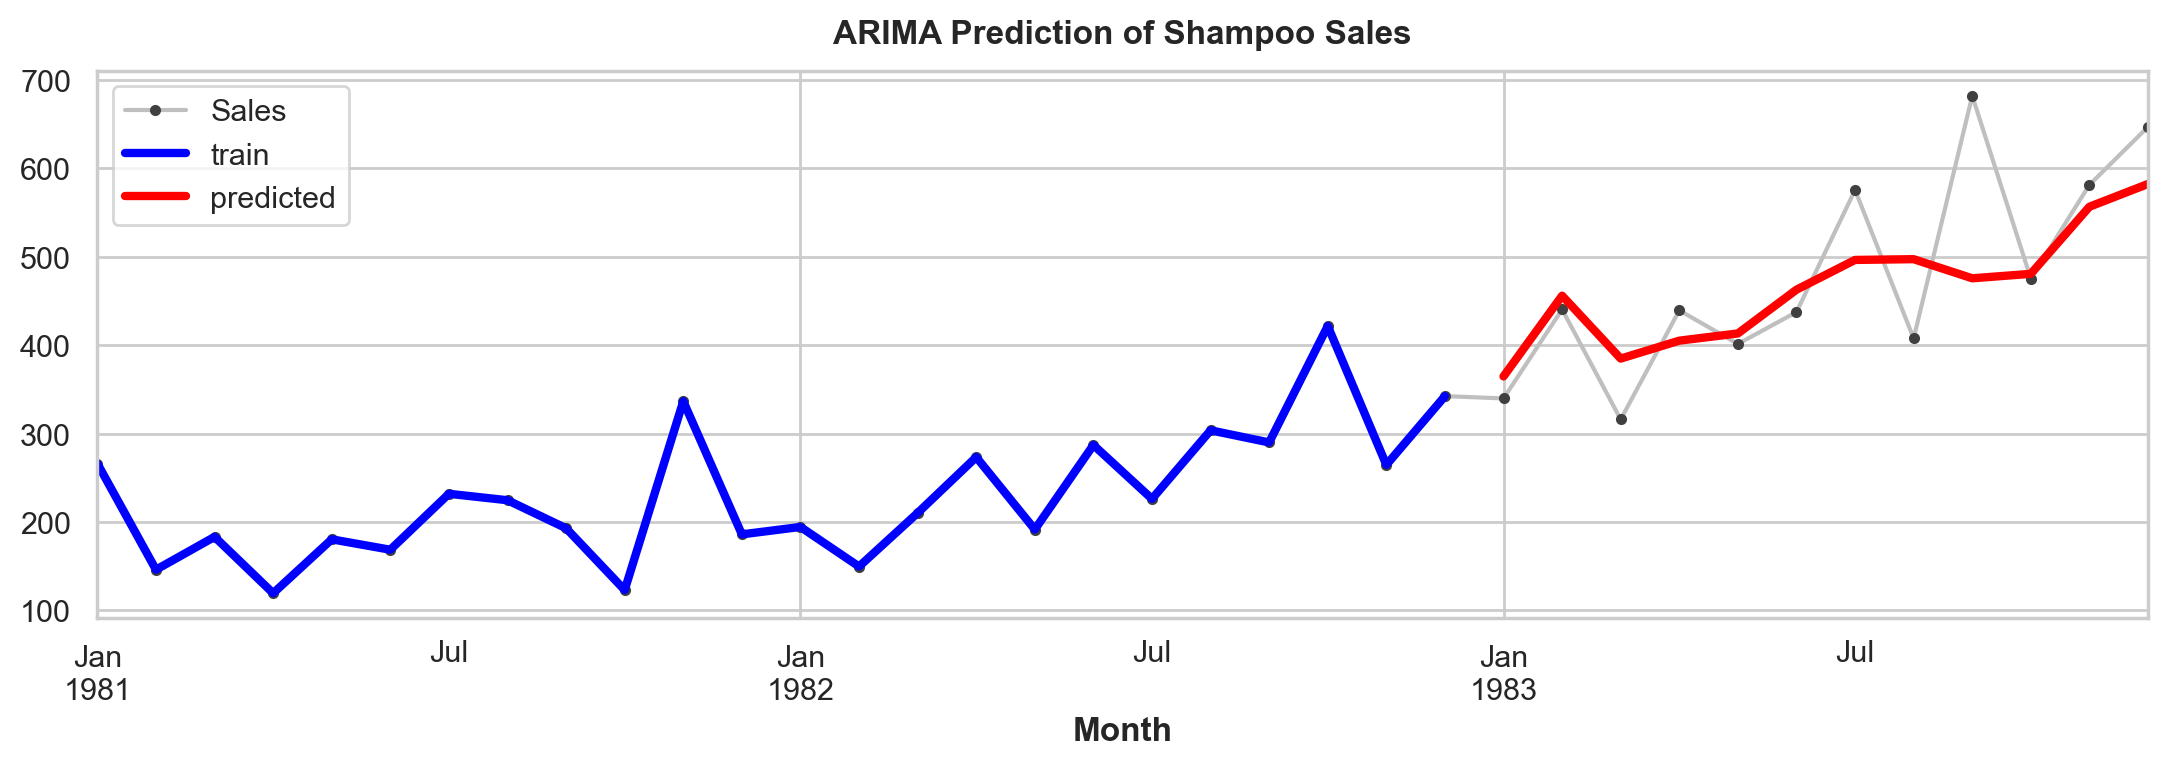

In [299]:
ax = df['Sales'].plot(**plot_params)
ax = train['Sales'].plot(ax=ax, linewidth=3, color='blue', label='train')
ax = forecast_diff_reverted.plot(ax=ax, linewidth=3, color='red', label='predicted')
ax.set_title('ARIMA Prediction of Shampoo Sales')
ax.legend();
plt.show()

In [295]:
mae = mean_absolute_error(y_test, forecast_diff_reverted)
print('Mean Absolute Error (MAE):', mae)

Mean Absolute Error (MAE): 57.6203308735675
